# Tricks to avoid Repeating Yourself.

## Avoid Boiler-Plate


Code can often be annoyingly full of "boiler-plate" code: characters you don't really want to have to type.

Not only is this tedious, it's also time-consuming and dangerous: unnecessary code is an unnecessary potential place for mistakes.

There are two important phrases in software design that we've spoken of before in this context:

> Once And Only Once

> Don't Repeat Yourself (DRY)

All concepts, ideas, or instructions should be in the program in just one place.
Every line in the program should say something useful and important.

We refer to code that respects this principle as DRY code.

In this lecture, we'll look at some techniques that can enable us to refactor away repetitive code.

Since in many of these places, the techniques will involve working with
functions as if they were variables, we'll learn some **functional**
programming. We'll also learn more about the innards of how Python implements
classes.

We'll also think about how to write programs that *generate* the more verbose, repetitive program we could otherwise write.
We call this **metaprogramming**.


### Metaprogramming Example


Consider a bunch of variables, each of which need initialising and incrementing:




In [1]:
bananas=0
apples=0
oranges=0
bananas+=1
apples+=1
oranges+=1



The right hand side of these assignments doesn't respect the DRY principle. We
could of course define a variable for our initial value:




In [2]:
initial_fruit_count=0
bananas=initial_fruit_count
apples=initial_fruit_count
oranges=initial_fruit_count



However, this is still not as DRY as it could be: what if we wanted to replace
the assignment with, say, a class constructor and a buy operation:




In [3]:
class Basket:
    def __init__(self):
        self.count=0
    def buy(self):
        self.count+=1

bananas=Basket()
apples=Basket()
oranges=Basket()
bananas.buy()
apples.buy()
oranges.buy()



We had to make the change in three places. Whenever you see a situation where a
refactoring or change of design might require you to change the code in
multiple places, you have an opportunity to make the code DRYer.

In this case, metaprogramming for incrementing these variables would involve
just a loop over all the variables we want to initialise:




In [4]:
baskets=[bananas, apples, oranges]
for basket in baskets: basket.buy()



However, this trick **doesn't** work for initialising a new variable:




In [5]:
from nose.tools import assert_raises
with assert_raises(NameError):
    baskets=[bananas, apples, oranges, kiwis]



So can we declare a new variable programmatically? Given a list of the
**names** of fruit baskets we want, initialise a variable with that name?




In [6]:
basket_names=['bananas', 'apples', 'oranges', 'kiwis']

globals()['apples']

<__main__.Basket instance at 0x10c505170>




Wow, we can! Every module or class in Python, is, under the hood, a special
dictionary, storing the values in its **namespace**. So we can create new
variables by assigning to this dictionary. globals() gives a reference to the
attribute dictionary for the current module




In [7]:
for name in basket_names:
    globals()[name]=Basket()


print kiwis.count

0




This is **metaprogramming**.

I would NOT recommend using it for an example as trivial as the one above. 
A better, more Pythonic choice here would be to use a data structure to manage your set of fruit baskets:




In [8]:
baskets={}
for name in basket_names:
    baskets[name]=Basket()

print baskets['kiwis'].count

0




Or even, using a dictionary comprehension:




In [9]:
baskets={name : Basket() for name in baskets}
print baskets['kiwis'].count

0




Which is the nicest way to do this, I think. Code which feels like
metaprogramming is needed to make it less repetitive can often instead be DRYed
up using a refactored data structure, in a way which is cleaner and more easy
to understand. Nevertheless, metaprogramming is worth knowing. 


## Functional programming

### Functional Programming


Understanding to think in a *functional programming* style is almost as
important as object orientation for building DRY, clear scientific software,
and is just as conceptually difficult.

Programs are composed of functions: they take data in (which we call
*parameters* or *arguments*) and send data out (through `return` statements.)

A conceptual trick which is often used by computer scientists to teach the core
idea of functional programming is this: to write a program,
in theory, you only ever need functions with **one** argument, even when you think you need two or more. Why?

Let's define a program to add two numbers:




In [10]:
def add(a,b):
    return a+b

add(5,6)

11



How could we do this, in a fictional version of Python which only defined functions of one argument?
In order to understand this, we'll have to understand several of the concepts
of functional programming. Let's start with a program which just adds five to
something:




In [11]:
def add_five(a):
    return a+5

add_five(6)

11



OK, we could define lots of these, one for each number we want to add. But that
would be infinitely repetitive. So, let's try to metaprogram that: we want a
function which returns these add_N() functions.

Let's start with the easy case: a function which returns a function which adds 5 to something:




In [ ]:

def generate_five_adder():
    def _add_five(a):
        return a+5
    return _add_five

coolfunction = generate_five_adder()
coolfunction(7)




OK, so what happened there? Well, we defined a function **inside** the other function. We can always do that:




In [12]:
def thirty_function():
    def times_three(a):
        return a*3
    def add_seven(a):
        return a+7
    return times_three(add_seven(3))

thirty_function()

30



When we do this, the functions enclosed inside the outer function are **local** functions, and can't be seen outside:




In [13]:
with assert_raises(NameError):
    add_seven



There's not really much of a difference between functions and other variables
in python. A function is just a variable which can have () put after it to call
the code!




In [14]:
print thirty_function
x=[thirty_function, add_five, add]

for fun in x:
    print fun

<function thirty_function at 0x10cc61e60>
<function thirty_function at 0x10cc61e60>
<function add_five at 0x10cc61d70>
<function add at 0x10cc61c80>




And we know that one of the things we can do with a variable is `return` it. So we can return a function, and then call it outside:




In [15]:
def deferred_greeting():
    def greet():
        print "Hello"
    return greet

friendlyfunction=deferred_greeting()

# Do something else
print "Just passing the time..."

# OK, Go!
friendlyfunction()

Just passing the time...
Hello





So now, to finish this, we just need to return a function to add an arbitrary amount:




In [16]:
def define_adder(increment):
    def adder(a):
        return a+increment
    return adder

add_3=define_adder(3)

add_3(9)

12



We can make this even prettier: let's make another variable pointing to our define_adder() function:




In [17]:
add = define_adder



And now we can do the real magic:




In [18]:
add(8)(5)

13

### Closures

You may have noticed something a bit weird:

In the definition of `define_adder`, `increment` is a local variable. It should have gone out of scope and died at the end of the definition. How can the amount the returned adder function is adding still be kept?

This is called a **closure**. In Python, whenever a function definition references a variable in the surrounding scope, it is preserved within the function definition.

You can close over global module variables as well:




In [19]:
name = "James"
def greet():
    print "Hello, ", name

greet()

Hello,  James




And note that the closure stores a reference to the variable in the surrounding scope: ("Late Binding")




In [20]:
name="Matt"

greet()

Hello,  Matt


### Map and Reduce

We often want to apply a function to each variable in an array, to return a new array. We can do this with a list comprehension:




In [21]:
numbers=range(10)

[add_five(i) for i in numbers]

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



But this is sufficiently common that there's a quick built-in:




In [22]:
map(add_five, numbers)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14]



This **map** operation is really important conceptually when understanding
efficient parallel programming: different computers can apply the *mapped*
function to their input at the same time. We call this Single Program, Multiple
Data. (SPMD) **map** is half of the **map-reduce** functional programming
paradigm which is key to the efficient operation of much of today's "data
science" explosion. 

Let's continue our functional programming mind-stretch by looking at **reduce** operations.

We very often want to loop with some kind of accumulator, such as when finding a mean, or finding a maximum:




In [23]:
def mean(data):
    sum=0.0
    for x in data:
        sum+=x
    return sum/len(data)

mean(range(10))

import sys
def my_max(data):
    # Start with the smallest possible number
    highest=sys.float_info.min
    for x in data:
        if x>highest:
            highest=x
    return highest

my_max([2,5,10,-11,-5])

10

These operations, where we have some variable which is building up a result,
and the result is updated with some operation, can be gathered together as a
functional program, taking in the operation to be used to combine results as an
argument:

In [24]:
def accumulate(initial, operation, data):
    accumulator=initial
    for x in data:
        accumulator=operation(accumulator, x)
    return accumulator

def my_sum(data):
    def _add(a,b):
        return a+b
    return accumulate(0, _add, data)

print my_sum(range(5))

def bigger(a,b):
    if b>a:
        return b
    return a

def my_max(data):
    return accumulate(sys.float_info.min, bigger, data)

print my_max([2,5,10,-11,-5])

10
10




Now, because these operations, _bigger, and _add, are such that e.g. (a+b)+c = a+(b+c) , i.e. they are **associative**, we could apply our accumulation
to the left half and the right half of the array, each on a different computer, and then combine the two halves:

1+2+3+4=(1+2)+(3+4)

Indeed, with a bigger array, we can divide-and-conquer more times:

1+2+3+4+5+6+7+8=((1+2)+(3+4))+((5+6)+(7+8))

So with enough parallel computers, we could do this operation on eight numbers
in three steps: first, we use four computers to do one  each of the pairwise
adds.

Then, we use two computers to add the four totals.

Then, we use one of the computers to do the final add of the two last numbers.

You might be able to do the maths to see that with an N element list, the
number of such steps is proportional to the logarithm of N.

We say that with enough computers, reduction operations are O(ln N)

This course isn't an introduction to algorithms, but we'll talk more about this
O() notation when we think about programming for performance.

Anyway, this accumulate-under-an-operation process, is so fundamental to
computing that it's usually in standard libraries for languages which allow
functional programming:




In [26]:
from functools import reduce

def my_max(data):
    return reduce(bigger,data,sys.float_info.min)

my_max([2,5,10,-11,-5])

10



When doing functional programming, we often want to be able to define a function on the fly:




In [27]:
def most_Cs_in_any_sequence(sequences):
    def count_Cs(sequence):
        return sequence.count('C')
    counts=map(count_Cs, sequences)
    return max(counts)

def most_Gs_in_any_sequence(sequences):
    return max(map(lambda sequence: sequence.count('G'),sequences))

data=[
    "CGTA",
    "CGGGTAAACG",
    "GATTACA"
]

most_Gs_in_any_sequence(data)

4



The syntax here is that these two definitions are identical:




In [28]:
func_name=lambda a,b,c : a+b+c

def func_name(a,b,c):
    a+b+c




lambda defines an "anonymous" function.




In [29]:
def most_of_given_base_in_any_sequence(sequences, base):
    return max(map(lambda sequence: sequence.count(base), sequences))

most_of_given_base_in_any_sequence(data,'A')

3



The above fragment defined a lambda function as a **closure** over `base`. If you understood that, you've got it! 




In [30]:
def my_max(data): return reduce(lambda a,b: a if a>b else b, data,
        sys.float_info.min)

my_max([2,5,10,-11,-5])

10

### Using functional programming


Probably the most common use in research computing for functional programming
is the application of a numerical method to a function. For example:


In [ ]:
% matplotlib inline

In [31]:
from scipy.optimize import newton
from numpy import linspace, zeros
from matplotlib import pyplot as plt
solve_me=lambda x: x**2-x

print newton(solve_me, 2), newton(solve_me,0.2)

xs=linspace(-1,2,50)
solved=[xs,map(solve_me,xs),xs,zeros(50)]
plt.plot(*solved)

1.0 -3.44190514264e-21





Sometimes such tools return another function:




In [32]:
def derivative(func, eps):
    def _func_derived(x):
        return (func(x+eps)-func(x))/eps
    return _func_derived

derived=(xs,map(solve_me,xs),xs,map(derivative(solve_me,0.01),xs))
plt.plot(*derived)
print newton(derivative(solve_me,0.01),0)

0.495


Of course, coding your own numerical methods is bad:

In [33]:
import scipy.misc

def derivative(func):
    def _func_derived(x):
        return scipy.misc.derivative(solve_me,x)
    return _func_derived

newton(derivative(solve_me),0)

0.5



If you've done a moderate amount of calculus, then you'll find similarities
between functional programming in computer science and Functionals in the
calculus of variations.



## Iterators and Generators

### Iterators


We've seen that in Python, anything which can be iterated over is called an iterable:




In [34]:
for key in baskets:
    print key.upper()

KIWIS
BANANAS
ORANGES
APPLES




Surprisingly often, we want to iterate over something that takes a moderately
large amount of storage to store. For example, our map images in the
green-graph example.

Our solution last time involved making an array of all the maps between London
and Birmingham. This kept them all in memory *at the same time*: first we
downloaded all the maps, then we counted the green pixels in each of them. This
would NOT work if we used more points. We could do this with a for loop and an
append(), but that's not as elegant as using a **generator**

Consider the basic python `range` function:




In [38]:
print range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [39]:
total=0
for x in range(int(1e6)): total+= x

total

499999500000



While this was executing, the range() statement allocated a million integers.
This is very inefficient. We don't actually need a million integers, just each
integer in turn up to a million.




In [40]:
print xrange(3)

a=iter(xrange(3))

xrange(3)


In [41]:
a.next()

0

In [42]:
a.next()

1

In [43]:
a.next()

2

In [44]:
with assert_raises(StopIteration):
    print a.next()

In [64]:
with assert_raises(StopIteration):
    print a.next()

total=0
for x in xrange(int(1e6)): total+= x

print total

499999500000


Similarly:

In [65]:
baskets.items()

[('kiwis', <__main__.Basket instance at 0x10cc750e0>),
 ('bananas', <__main__.Basket instance at 0x10cc75128>),
 ('oranges', <__main__.Basket instance at 0x10cc75170>),
 ('apples', <__main__.Basket instance at 0x10cc751b8>)]

In [66]:
baskets.iteritems()

<dictionary-itemiterator at 0x113bd6a48>




We can make our own iterators by defining classes that implement next() and __iter__() methods: this is the iterator protocol.

For each of the concepts we've talked about, python defines a protocol, a set of methods a class must implement, in order to be treated as a member of that concept.

For the iterator protocol, the protocol that defines things that support `for x in y:`, the methods that must be supported are `next()` and `__iter__()`.




In [67]:
class fib_iterator(object):
    def __init__(self, limit, seed1=1, seed2=1):
        self.limit=limit
        self.previous=seed1
        self.current=seed2
    def __iter__(self):
        return self
    def next(self):
        (self.previous, self.current)=(
                self.current, self.previous+self.current)
        self.limit -=1
        if self.limit<0: raise StopIteration() # This will be 
                                 # explained in a few slides!
        return self.current

In [68]:
x=fib_iterator(5)

In [69]:
x.next()

2

In [70]:
x.next()

3

In [71]:
x.next()

5

In [72]:
x.next()

8

In [73]:
for x in fib_iterator(5):
    print x

2
3
5
8
13


In [74]:
sum(fib_iterator(5))

31




In fact, if, to be iterated over, a class just wants to behave as if it were some other iterable, you can just implement `__iter__` and return `iter(some_other_iterable)`, without implementing `next`.  For example, an image class might want to implement some metadata, but behave just as if it were just a 1-d pixel array when being iterated:




In [75]:
from numpy import array
class MyImage(object):
    def __init__(self, pixels):
        self.pixels=array(pixels,dtype='uint8')
        self.channels=self.pixels.shape[2]
    def __iter__(self):
        # return an iterator over the pixels
        # See future NumPy lecture for using reshape
        return iter(self.pixels.reshape(-1,self.channels))
    def show(self):
        plt.imshow(self.pixels, interpolation="None")

x=[[[255,255,0],[0,255,0]],[[0,0,255],[255,255,255]]]
image=MyImage(x)

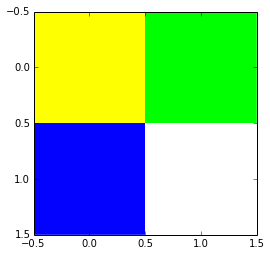

In [80]:
%matplotlib inline
image.show()

In [81]:
image.channels

3

In [83]:
from webcolors import rgb_to_name
for pixel in image:
    print rgb_to_name(pixel)

yellow
lime
blue
white





Technically, the **iterator** protocol is to implement both `__iter__` and
`next`, while the **iterable** protocol is to implement `__iter__` and return
an **iterator**.


### Generators


There's a fair amount of "boiler-plate" in the above class-based definition of
an iterable. Python provides another way to specify something
which meets the iterator protocol: generators.




In [84]:
def my_generator():
    yield 5
    yield 10

x=my_generator()
print x.next()
print x.next()

with assert_raises(StopIteration):
    print x.next()

5
10





A function which has `yield` statements instead of a `return` statement returns
**temporarily**. Each call of next() returns control to the function. Where it
left off. Control passes back-and-forth between the generator and the caller.
Our fibonacci example therefore becomes:




In [87]:
def yield_fibs(limit, seed1=1,seed2=1):
    current=seed1
    previous=seed2
    while limit>0:
        limit-=1
        current, previous = current+previous, current
        yield current

In [88]:
print sum(yield_fibs(5))

31


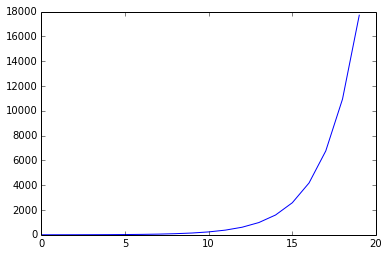

In [89]:
plt.plot(list(yield_fibs(20)))

## Exceptions

### Exceptions


When we learned about testing, we saw that Python complains when things go wrong by raising an "Exception" naming a type of error:




In [90]:
with assert_raises(ZeroDivisionError):
    1/0



Exceptions are objects, forming a class hierarchy. We just raised an instance
of the ZeroDivisionError class, making the program crash.




In [91]:
import inspect
inspect.getmro(ZeroDivisionError)

(ZeroDivisionError,
 ArithmeticError,
 StandardError,
 Exception,
 BaseException,
 object)



So we can see that a zero division error is a particular kind of Arithmetic Error.




In [92]:
x=1
with assert_raises(TypeError):
    for y in x: print y

inspect.getmro(TypeError)

(TypeError, StandardError, Exception, BaseException, object)




When we were looking at testing, we saw that it is important for code to crash with a meaningful exception type when something is wrong.
We raise an Exception with `raise`. Often, we can look for an appropriate exception from the standard set to raise. 

However, we may want to define our own exceptions. Doing this is as simple as inheriting from Exception:




In [93]:
class MyCustomErrorType(Exception):
    pass

with assert_raises(MyCustomErrorType):
    raise(MyCustomErrorType("Problem"))



You can add custom data to your exception:




In [94]:
class MyCustomErrorType(Exception):
    def __init__(self, category=None):
        self.category=category
    def __str__(self):
        return "Error, cateory " + str(self. category)

with assert_raises(MyCustomErrorType):
    raise(MyCustomErrorType(404))



The real power of exceptions comes, however, not in letting them crash the program, but in letting your program handle them. We say that an exception has been "thrown" and then "caught".




In [95]:
import yaml
try:
    config=yaml.load(open("datasource.yaml"))
    user=config["userid"]
    password=config["password"]
except IOError:
    user="anonymous"
    password=None

print user

anonymous




Note that we specify only the error we expect to happen and want to handle. Sometimes you see code that catches everything:




In [96]:
try:
    config=yaml.lod(open("datasource.yaml"))
    user=config["userid"]
    password=config["password"]
except:
    user="anonymous"
    password=None

print user

anonymous




There was a mistyped function name there, but we did not notice the error, as the generic except caught it. 
Therefore, we should catch only the error we want.




In [97]:
with open('datasource2.yaml','w') as outfile:
    outfile.write('userid: jamespjh\n')
    outfile.write('password: secret\n')

with open('datasource3.yaml','w') as outfile:
    outfile.write('user: jamespjh\n')
    outfile.write('password: secret\n')

def read_credentials(source):
    try:
       datasource=open(source)
       config=yaml.load(datasource)
       user=config["userid"]
       password=config["password"]
       datasource.close()
    except IOError:
       user="anonymous"
       password=None
    return user, password

print read_credentials('datasource2.yaml')

print read_credentials('datasource.yaml')

with assert_raises(KeyError):
    print read_credentials('datasource3.yaml')


('jamespjh', 'secret')
('anonymous', None)





This last code has a flaw: the file was successfully opened, the missing key was noticed, but not explicitly closed. It's normally OK, as python will close the file as soon as it notices there are no longer any references to datasource in memory, after the function exits. But this is not good practice, you should keep a file handle for as short a time as possible.




In [98]:
def read_credentials(source):
    try:
       datasource=open(source)
       config=yaml.load(datasource)
       user=config["userid"]
       password=config["password"]
    except IOError:
       user="anonymous"
       password=None
    finally:
        datasource.close()
    return user, password




The `finally` clause is executed whether or not an exception occurs.

The last optional clause of a `try` statement, an `else` clause is called only if an exception is NOT raised. It can be a better place than the `try` clause to put code other than that which you expect to raise the error, and which you do not want to be executed if the error is raised. It is executed in the same circumstances as code put in the end of the `try` block, the only difference is that errors raised during the `else` clause are not caught. Don't worry if this seems useless to you; most languages implementations of try/except don't support such a clause.




In [99]:
def read_credentials(source):
    try:
       datasource=open(source)
    except IOError:
       user="anonymous"
       password=None
    else:
       config=yaml.load(datasource)
       user=config["userid"]
       password=config["password"]
    finally:
        datasource.close()
    return user, password



Exceptions do not have to be caught close to the part of the program calling
them. They can be caught anywhere "above" the calling point in
the call stack: control can jump arbitrarily far in the program: up to the `except` clause of the "highest" containing try statement.




In [104]:
def f4(x):
    if x==0:
        return
    if x==1:
        raise ArithmeticError()
    if x==2:
        raise SyntaxError()
    if x==3:
        raise TypeError()

In [105]:
def f3(x):
    try:
        print "F3Before"
        f4(x)
        print "F3After"
    except ArithmeticError:
        print "F3Except"

In [106]:
def f2(x):
    try:
        print "F2Before"
        f3(x)
        print "F2After"
    except SyntaxError:
        print "F2Except"

In [107]:
def f1(x):
    try:
        print "F1Before"
        f2(x)
        print "F1After"
    except TypeError:
        print "F1Except"

In [108]:
f1(0)

F1Before
F2Before
F3Before
F3After
F2After
F1After


In [109]:
f1(1)

F1Before
F2Before
F3Before
F3Except
F2After
F1After


In [110]:
f1(2)

F1Before
F2Before
F3Before
F2Except
F1After


In [111]:
f1(3)

F1Before
F2Before
F3Before
F1Except


### Design with Exceptions


Now we know how exceptions work, we need to think about the design implications... How best to use them.

Traditional software design theory will tell you that they should only be used
to describe and recover from **exceptional** conditions: things going wrong.
Normal program flow shouldn't use them.

Python's designers take a different view: use of exceptions in normal flow is
considered OK. For example, all iterators raise a `StopIteration` exception to
indicate the iteration is complete.

A commonly recommended python design pattern is to use exceptions to determine
whether an object implments a protocol (concept/interface), rather than testing
on type.

For example, we might want a function which can be supplied *either* a data
series *or* a path to a location on disk where data can be found. We can
examine the type of the supplied content:




In [113]:
import yaml
def analysis(source):
    if type(source)==dict:
        name=source['modelname']
    else:
        content=open(source)
        source=yaml.load(content)
        name=source['modelname']
    print name

In [114]:
analysis({'modelname':'Super'})

Super


In [115]:
with open('example.yaml','w') as outfile:
    outfile.write('modelname: brilliant\n')

In [116]:
analysis('example.yaml')

brilliant





However, we can also use the try-it-and-handle-exceptions approach to this. 




In [117]:
def analysis(source):
    try:
      name=source['modelname']
    except TypeError:
      content=open(source)
      source=yaml.load(content)
      name=source['modelname']
    print name

analysis('example.yaml')

brilliant


This approach is more extensible, and **behaves properly if we give it some
other data-source which responds like a dictionary or string.**

In [118]:
def analysis(source):
    try:
      name=source['modelname']
    except TypeError:
      # Source was not a dictionary-like object
      # Maybe it is a file path
      try:
        content=open(source)
        source=yaml.load(content)
        name=source['modelname']
      except IOError:
        # Maybe it was already raw YAML content
        source=yaml.load(source)
        name=source['modelname']
    print name

analysis("modelname: Amazing")

Amazing





Sometimes we want to catch an error, partially handle it, perhaps add some
extra data to the exception, and then re-raise to be caught again further up
the call stack. 

The keyword "`raise`" with no argument in an `except:` clause will cause the
caught error to be re-thrown. Doing this is the only circumstance where it is
safe to do except: without catching a specfic type of error.




In [119]:
try:
    # Something
    pass
except:
    # Do this code here if anything goes wrong
    raise



It can be useful to catch and re-throw an error as you go up the chain, doing any clean-up needed for each layer of a program.

The error will finally be caught and not re-thrown only at a higher program
layer that knows how to recover. This is known as the "throw low catch high"
principle.




## Context managers and decorators

### Context managers


We saw that instead of separately `open`ing and `close`ing a file, we can have
the file be automatically closed using a context manager:




In [121]:
with open('example.yaml') as foo:
    print yaml.load(foo)

{'modelname': 'brilliant'}





How could we define our own one of these, if we too have clean-up code we
always want to run after a calling function has done its work, or set-up code
we want to do first?

We can define a class that meets an appropriate protocol:




In [122]:
class verbose_context():
    def __init__(self, name):
        self.name=name
    def __enter__(self):
        print "Get ready, ", self.name
    def __exit__(self, exc_type, exc_value, traceback):
        print "OK, done"

with verbose_context("James"):
    print "Doing it!"

Get ready,  James
Doing it!
OK, done




However, this is pretty verbose! Again, a generator with `yield` makes for an easier syntax:




In [123]:
from contextlib import contextmanager

@contextmanager
def verbose_context(name):
    print "Get ready for action, ", name
    yield name.upper()
    print "You did it"

with verbose_context("James") as shouty:
    print "Doing it, ",  shouty

Get ready for action,  James
Doing it,  JAMES
You did it




Again, we use `yield` to temporarily return from a function.


### Decorators


When doing functional programming, we may often want to define mutator
functions which take in one function and return a new function, such as our
derivative example earlier.




In [124]:
def repeater(func, count):
    def _repeated(x):
        counter=count
        while counter>0:
            counter-=1
            x=func(x)
        return x
    return _repeated

from math import sqrt

fiftyroots=repeater(sqrt,50)

print fiftyroots(100)

1.0





It turns out that, quite often, we want to apply one of these to a function as we're defining a class.
For example, we may want to specify that after certain methods are called, data should always be stored:




In [125]:
def reset_required(func):
    def _with_data_save(self, *args):
        func(self,*args)
        self.stored_data.append(self.data)
    return _with_data_save

class SomeClass(object):
    def __init__(self):
        self.data=[]
        self.stored_data=[]
    def _step1(self, ins):
        self.data=[x*2 for x in ins]
    step1=reset_required(_step1)

In [126]:
x=SomeClass()

In [127]:
x.step1("Hello")
print x.data

['HH', 'ee', 'll', 'll', 'oo']


In [128]:
x.step1("World")
print x.data

['WW', 'oo', 'rr', 'll', 'dd']


In [129]:
print x.stored_data

[['HH', 'ee', 'll', 'll', 'oo'], ['WW', 'oo', 'rr', 'll', 'dd']]





Python provides some "syntactic sugar" to make this kind of coding prettier:




In [ ]:
def reset_required(func):
    def _with_data_save(self, *args):
        func(self,*args)
        self.stored_data.append(self.data)
    return _with_data_save

class SomeClass(object):
    def __init__(self):
        self.data=[]
        self.stored_data=[]
    @reset_required
    def step1(self, ins):
        self.data=[x*2 for x in ins]

x=SomeClass()
x.step1("Hello")
x.step1("World")
print x.stored_data


Any function which accepts a function as its first argument and returns a function can be used as a **decorator** like this.

Much of Python's standard functionality is implemented as decorators: we've
seen @contextmanager, @classmethod and @attribute. The @contextmanager
metafunction, for example, takes in an iterator, and yields a class conforming
to the context manager protocol.


### Testing and functional programming.


A few weeks ago we saw a test which loaded its test cases from a YAML file and
asserted each input with each output. This was nice and concise, but had one
flaw: we had just one test, covering all the fixtures, so we got just one . in
the test output when we ran the tests, and if any test failed, the rest were
not run. We can do a nicer job with a test **generator**:




In [130]:
def assert_examplar(**fixture):
    answer=fixture.pop('answer')
    assert_equal(greet(**fixture), answer)

def test_greeter():
    with open(os.path.join(os.path.dirname(
        __file__),'fixtures','samples.yaml')
        ) as fixtures_file:
        fixtures=yaml.load(fixtures_file)
        for fixture in fixtures:
            yield assert_exemplar(**fixture)

We also remember seeing `with assert_raises()` used to do negative testing.

We can now imagine how this context manager might be implemented:

In [132]:
@contextmanager
def my_assert_raises(exception):
    try:
        yield
    except exception:
        pass
    else:
        raise Exception("Expected,", exception, 
                " to be raised, nothing was.")



In fact, we can now use an even easier way to define negative tests: by using `@raises` as a **decorator**:




In [133]:
from nose.tools import raises

@raises(TypeError, ValueError)
def test_raises_type_error():
    raise TypeError("This test passes")

@raises(Exception)
def test_that_fails_by_passing():
    pass

test_raises_type_error()

with assert_raises(AssertionError):
    test_that_fails_by_passing()




Again, we can imagine how nose might implement this:




In [134]:
def my_raises(func, exception):
    def _output(*args):
        with assert_raises(exception):
            func(*args)
    return _output

## Metaprogramming

### Metaprogramming class attributes


In our introductory metaprogramming example, we were working in the root namespace of a module, using the globals() function.

We want to be able to access the attribute dictionary for other objects to do
metaprogramming to, for example, programmatically create class member data or
variables.




In [ ]:
class Boring(object): 
    pass

In [141]:
x=Boring()

x.name="James"

In [142]:
x.name

'James'

In [143]:
x.__dict__

{'name': 'James'}

In [144]:
getattr(x,'name')

'James'

In [145]:
setattr(x,'age',38)

x.age

38




The real power of accessing the attribute dictionary comes when we realise that
there is *very little difference* between member data and member functions.
Now that we know, from our functional programming, that a function is just a
variable that can be *called* with `()`, we can set an attribute to a function,
and
it becomes a member function!




In [147]:
setattr(Boring, 'describe', lambda self: self.name+ " is "+str(self.age))

In [148]:
x.describe()

'James is 38'

In [149]:
x.describe

<bound method Boring.<lambda> of <__main__.Boring object at 0x114f99710>>

In [150]:
Boring.describe

<unbound method Boring.<lambda>>




Note that we set this as an attribute of the class, so it is available to other instances of `Boring`:




In [152]:
y=Boring()

y.describe()

AttributeError: 'Boring' object has no attribute 'name'

In [153]:
def broken_birth_year(self):
    import datetime
    current=datetime.datetime.now().year
    return current-self.age

In [154]:
Boring.birth_year=broken_birth_year

In [155]:
x.birth_year()

1977

In [156]:
x.birth_year

<bound method Boring.broken_birth_year of <__main__.Boring object at 0x114f99710>>

In [157]:
broken_birth_year.__name__

'broken_birth_year'




We can access the attribute dictionary for the local namespace inside a
function with locals() but this *cannot safely be written to*. Lack of safe
programmatic creation of local variables is a flaw in Python.




In [161]:
class Person(object):
    def __init__(self, name, age, job, children_count):
        for name,value in locals().iteritems():
            if name=='self': continue
            print "Setting self.", name, " to ", value 
            setattr(self, name, value)

In [162]:
me=Person("James", 38, "Scientific Programmer", 0)

Setting self. job  to  Scientific Programmer
Setting self. children_count  to  0
Setting self. age  to  38
Setting self. name  to  James


In [163]:
me.name

'James'

### Metaprogramming warning!


Use this stuff **sparingly**!

The above example worked, but it produced Python code which is not particularly understandable.
Remember, your objective when programming is to produce code which is **descriptive of what it does**.

The above code is **definitely** less readable, less maintainable and more error prone than:




In [165]:
class Person(object):
    def __init__(self, name, age, job, children_count):
       self.name=name
       self.age=age
       self.job=job
       self.children_count=children_count




Sometimes, metaprogramming will be **really** helpful in making non-repetitive
code, and you should have it in your toolbox, which is why I'm teaching you it.
But doing it all the time overcomplicated matters. We've talked a lot about the
DRY principle, but there is another equally important principle:

> **KISS**: *Keep it simple, Stupid!*

Whenever you write code and you think, "Gosh, I'm really clever",you're
probably *doing it wrong*. Code should be about clarity, not showing off.


## Operator overloading

### Operator overloading




We need to use a metaprogramming trick to make this notebook work.
I want to be able to put explanatory text in between parts of a class definition,
so I'll define a decorator to help me build up a class definition gradually.




In [166]:
def extend(class_to_extend):
    """ Metaprogramming to allow gradual implementation
    of class during notebook. Thanks to
    http://www.ianbicking.org/blog/2007/08/opening-python-classes.html """
    def decorator(extending_class):
        for name, value in extending_class.__dict__.iteritems():
            if name in ['__dict__','__module__', '__weakref__', '__doc__']:
                continue
            setattr(class_to_extend,name,value)
        return class_to_extend
    return decorator





Imagine we wanted to make a library to describe some kind of symbolic algebra system:




In [168]:
class Term(object):
    def __init__(self, symbols=[], powers=[], coefficient=1):
        self.coefficient=coefficient
        self.data={symbol: exponent for symbol,exponent
                in zip(symbols, powers)}

class Expression(object):
    def __init__(self, terms):        self.terms=terms





So that $5x^2y+7x+2$ might be constructed as:




In [170]:
first=Term(['x','y'],[2,1],5)
second=Term(['x'],[1],7)
third=Term([],[],2)
result=Expression([first, second, third])




This is pretty cumbersome.

What we'd really like is to have `2x+y` give an appropriate expression.

First, we'll define things so that we can construct our terms and expressions in different ways.




In [173]:

class Term(object):
    def __init__(self, *args):
        lead=args[0]
        if type(lead)==type(self):
            # Copy constructor
            self.data=dict(lead.data)
            self.coefficient=lead.coefficient
        elif type(lead)==int:
            self.from_constant(lead)
        elif type(lead)==str:
            self.from_symbol(*args)
        elif type(lead)==dict:
            self.from_dictionary(*args)
        else:
            self.from_lists(*args)
            
    def from_constant(self, constant):
        self.coefficient=constant
        self.data={}
        
    def from_symbol(self, symbol, coefficient=1, power=1):
        self.coefficient=coefficient
        self.data={symbol:power}
        
    def from_dictionary(self, data, coefficient=1):
        self.data=data
        self.coefficient=coefficient
        
    def from_lists(self, symbols=[], powers=[], coefficient=1):
        self.coefficient=coefficient
        self.data={symbol: exponent for symbol,exponent
                in zip(symbols, powers)}

In [174]:
class Expression(object):
    def __init__(self, terms=[]):
        self.terms=list(terms)




We could define add() and multiply() operations on expressions and terms:




In [178]:
@extend(Term)
class Term(object):
    def add(self, *others):
        return Expression((self,)+others)
    

In [179]:
@extend(Term)
class Term(object):
    def multiply(self, *others):
        result_data=dict(self.data)
        result_coeff=self.coefficient
        # Convert arguments to Terms first if they are
        # constants or integers
        others=map(Term,others)
        for another in others:
            for symbol, exponent in another.data.iteritems():
                if symbol in result_data:
                    result_data[symbol]+=another.data[symbol]
                else:
                    result_data[symbol]=another.data[symbol]
            result_coeff*=another.coefficient
        return Term(result_data,result_coeff)

In [180]:
@extend(Expression)
class Expression(object):
    def add(self, *others):
        result=Expression(self.terms)
        for another in others:
            if type(another)==Term:
                result.terms.append(another)
            else:
                result.terms+=another.terms
        return result




We can now construct the above expression as:




In [181]:
x=Term('x')
y=Term('y')

first=Term(5).multiply(Term('x'),Term('x'),Term('y'))
second=Term(7).multiply(Term('x'))
third=Term(2)
expr=first.add(second,third)




This is better, but we still can't write the expression in a 'natural' way.

However, we can define what `*` and `+` do when applied to Terms!:




In [182]:
@extend(Term)
class Term(object):
    def __add__(self, other):
        return self.add(other)
    def __mul__(self, other):
        return self.multiply(other)

In [183]:
@extend(Expression)
class Expression(object):
    def multiply(self, another):
        # Distributive law left as exercise
        pass
    
    def __add__(self, other):
        return self.add(other)

In [185]:
x_plus_y=Term('x')+'y'
x_plus_y.terms[0].data

{'x': 1}

In [186]:
five_x_ysq=Term('x')*5*'y'*'y'
print five_x_ysq.data, five_x_ysq.coefficient

{'y': 2, 'x': 1} 5





This is called operator overloading. We can define what add and multiply mean when applied to our class.

Note that this only works so far if we multiply on the right-hand-side!
However, we can define a multiplication that works backwards, which is used as a fallback if the left multiply raises an error:




In [187]:
@extend(Expression)
class Expression(object):
    def __radd__(self, other):
        return self.__add__(other)

In [188]:
@extend(Term)
class Term(object):
    def __rmul__(self, other):
        return self.__mul__(other)
    def __radd__(self, other):
        return self.__add__(other)

In [189]:
print 5*Term('x')




It's not easy at the moment to see if these things are working!




In [190]:
fivex=5*Term('x')
print fivex.data, fivex.coefficient

{'x': 1} 5





We can add another operator method `__str__`, which defines what happens if we try to print our class:




In [192]:
@extend(Term)
class Term(object):
    def __str__(self):
        def symbol_string(symbol, power):
            if power==1:
                return symbol
            else:
                return symbol+'^'+str(power)
            
        symbol_strings=[symbol_string(symbol, power)
                for symbol, power in self.data.iteritems()]
        
        prod='*'.join(symbol_strings)
        
        if not prod:
            return str(self.coefficient)
        if self.coefficient==1:
            return prod
        else:
            return str(self.coefficient)+'*'+prod

In [193]:
@extend(Expression)
class Expression(object):
    def __str__(self):
        return '+'.join(map(str,self.terms))

In [194]:
first=Term(5)*'x'*'x'*'y'
second=Term(7)*'x'
third=Term(2)
expr=first+second+third

In [195]:
print expr

5*y*x^2+7*x+2





We can add lots more operators to classes. `__eq__` to determine if objects are
equal. `__getitem__` to apply [1] to your object. Probably the most exciting
one is `__call__`, which allows us to define other classes that *behave like
functions*! We call these callables.




In [196]:
class MyCallable(object):
    def __call__(self, name):
        print "Hello, ", name

x=MyCallable()

x("James")

Hello,  James





We've now come full circle in the blurring of the distinction between functions and objects! The full power of functional programming is really remarkable.

If you want to know more about the topics in this lecture, using a different
language syntax, I recommend you watch the [Abelson and Sussman](https://www.youtube.com/watch?v=2Op3QLzMgSY)
"Structure and Interpretation of Computer Programs" lectures. These are the Computer Science
equivalent of the Feynman Lectures!


## Exercise

### Exercise

Numbers have units. $5\mathrm{m}^2$ is not $5\mathrm{J}$. 

$6\mathrm{J}$ is the
same as $6\mathrm{kg}\mathrm{m}^2\mathrm{s}^{-2}$ which is the same as
$2\mathrm{N} \cdot 3\mathrm{m}$

Write a python library to implement handling quantities with units, and
converting between units, with a github repostiory and a setup.py file, and
some unit tests.

You should define operators for multiply, equality, and add for your class.

Your unit tests should include things like:

``` python
assert(5*meters == 0.005*kilometers)
assert((60*seconds).to(minutes).value==1)
assert((60*seconds).to(minutes).unit==minutes)
with assert_raises(IncompatibleUnitsError):
    5*meters+2*seconds
```

You don't have to implement every unit! You might want to load your unit definitions from a yaml config file.